In [1]:
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# this helps with scrolling df
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

In [23]:
# function for data manipulation 
def df_unpack_list(df_column):
    """
    Args:
        df_column: column from dataframe in format df['column']

    Returns:
        pivoted: df with unpacked list to columns
    """
    # extract series name
    series_name = df_column.name
    
    # unpack list and bring it into dataframe with 0,1 values
    exploded_list = pd.DataFrame(df_column.explode(), index = df_column.explode().index)
    exploded_list.fillna('empty', inplace = True)
    exploded_list['values'] = 1
    pivoted = exploded_list.pivot(columns=series_name, values='values')
    pivoted.fillna(0, inplace = True)
    
    # adjust colum names
    column_names = [series_name + '.' + col.lower() for col in pivoted.columns]
    pivoted.columns = column_names
    
    return pivoted
    

In [3]:
# function for plots

def plot_histogram(df, variable, density = False):
    """
    Args:
        df: data frame with categoretical variable and label named as "label"
        column: string - name of column with categorical data
        
    Returns:
        prints histogram based on label split
    
    """
    plt.tight_layout() 
    plt.figure(figsize=(8,6))
    sns.countplot(x=variable, hue="label", data=df, palette="hls")
    plt.title("Count of label vs size bins",fontsize=20)
    plt.xlabel("Bin size",fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.xticks(rotation=45)
    plt.legend(['non-malware','malware'],loc='upper right')
    
    plt.show()

from scipy.stats import chi2  

def chi_2(df, variable):
    
    cross_table = pd.crosstab(df['label'],df[variable])
    chi2, p, dof, ex = stats.chi2_contingency(cross_table) 
    alpha = 0.05
    

    print('chi_2 statistic: {:.2f}'.format(chi2))
    print('p_value: {:.2f}'.format(p))
    print("significant level", alpha)
    
    if p <=alpha:
        print('Reject H0, variables have dependency')
    else:
        print('Do not reject H0')

def plot_chi(df, variable):
    plot_histogram(df, variable)
    chi_2(df, variable)

In [4]:
# import JSON
df_all = pd.read_json('sample_data_6k.jsonl', lines=True)

In [5]:
df = df_all[df_all.label!=-1].copy()

In [6]:
df.label.value_counts()

0    2750
1    1932
Name: label, dtype: int64

In [7]:
sample = pd.concat([df[df.label==1], df[df.label==0].sample(1932,random_state=3)])

In [8]:
# shape looks ok 
sample.label.value_counts()


0    1932
1    1932
Name: label, dtype: int64

In [9]:
# let's print some data
df.head(2)

,sha256,md5,appeared,label,avclass,histogram,byteentropy,strings,general,header,section,imports,exports,datadirectories
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,63956d6417f8f43357d9a8e79e52257e,2006-12,0,,"[45521, 13095, 12167, 12496, 12429, 11709, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'numstrings': 14573, 'avlength': 5.9720716393...","{'size': 3101705, 'vsize': 380928, 'has_debug'...","{'coff': {'timestamp': 1124149349, 'machine': ...","{'entry': '.text', 'sections': [{'name': '.tex...","{'KERNEL32.dll': ['SetFileTime', 'CompareFileT...",[],"[{'name': 'EXPORT_TABLE', 'size': 0, 'virtual_..."
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,6f7bde7a1126debf0cc359a54953efc1,2007-01,0,,"[93059, 15789, 2871, 3005, 4107, 1771, 2918, 4...","[47100, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,...","{'numstrings': 1803, 'avlength': 11.1913477537...","{'size': 504320, 'vsize': 524288, 'has_debug':...","{'coff': {'timestamp': 1091600092, 'machine': ...","{'entry': '.text', 'sections': [{'name': '.tex...",{'ADVAPI32.dll': ['ConvertStringSecurityDescri...,[],"[{'name': 'EXPORT_TABLE', 'size': 0, 'virtual_..."


### Variable sha256

In [25]:
df.sha256.nunique() # all hashes are unique, good candidate for unique_id

6000

### Variable "header"

In [104]:
header = pd.json_normalize(sample.header)

In [105]:
header['label']= sample.label

In [106]:
header.head(2)

,coff.timestamp,coff.machine,coff.characteristics,optional.subsystem,optional.dll_characteristics,optional.magic,optional.major_image_version,optional.minor_image_version,optional.major_linker_version,optional.minor_linker_version,optional.major_operating_system_version,optional.minor_operating_system_version,optional.major_subsystem_version,optional.minor_subsystem_version,optional.sizeof_code,optional.sizeof_headers,optional.sizeof_heap_commit,label
0,1301832471,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA...",WINDOWS_GUI,[],PE32,0,0,2,50,4,0,4,0,8704,1024,4096,0.00
1,1511340343,I386,"[CHARA_32BIT_MACHINE, EXECUTABLE_IMAGE]",WINDOWS_GUI,"[DYNAMIC_BASE, NX_COMPAT, TERMINAL_SERVER_AWARE]",PE32,0,0,14,11,5,1,5,1,262144,1024,4096,0.00


In [28]:
header.dtypes

coff.timestamp                              int64
coff.machine                               object
coff.characteristics                       object
optional.subsystem                         object
optional.dll_characteristics               object
optional.magic                             object
optional.major_image_version                int64
optional.minor_image_version                int64
optional.major_linker_version               int64
optional.minor_linker_version               int64
optional.major_operating_system_version     int64
optional.minor_operating_system_version     int64
optional.major_subsystem_version            int64
optional.minor_subsystem_version            int64
optional.sizeof_code                        int64
optional.sizeof_headers                     int64
optional.sizeof_heap_commit                 int64
dtype: object

#### 2.  coff.machine

In [46]:
header['coff.machine'].value_counts()

I386     4347
AMD64     325
???         4
ARMNT       2
THUMB       1
ARM         1
IA64        1
R4000       1
Name: coff.machine, dtype: int64

<Figure size 432x288 with 0 Axes>

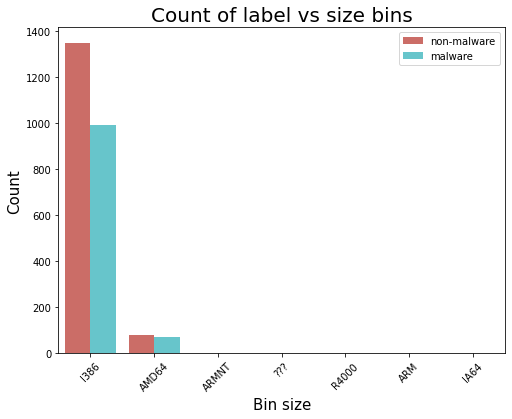

chi_2 statistic: 4.83
p_value: 0.31
significant level 0.05
Do not reject H0


In [107]:
plot_chi(header,'coff.machine')

In [ ]:
# Exclude from model

### optional.subsystem

<Figure size 432x288 with 0 Axes>

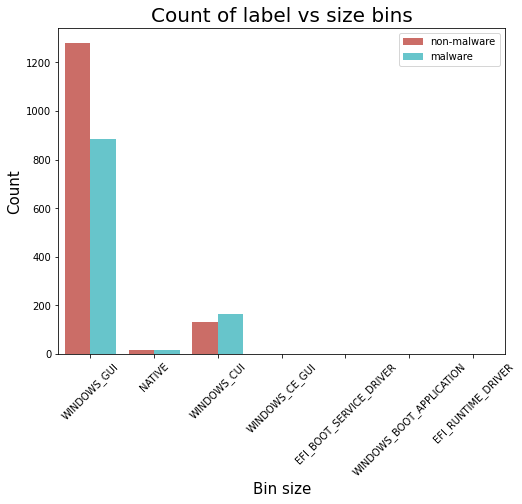

chi_2 statistic: 26.41
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [110]:
plot_chi(header,'optional.subsystem')
# do not exclude

<Figure size 432x288 with 0 Axes>

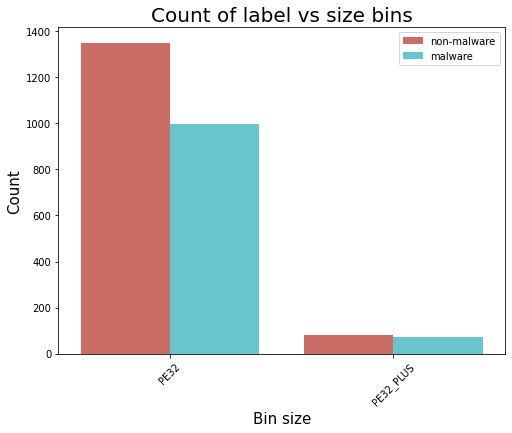

chi_2 statistic: 1.03
p_value: 0.31
significant level 0.05
Do not reject H0


In [111]:
plot_chi(header,'optional.magic')
#exclude from model

### optional.major_image_version	

In [113]:
header['optional.major_image_version'].value_counts()

0        2861
6         308
1         211
10        177
5         170
4          42
3          19
2          17
40         16
8          16
7           7
13          4
502         3
21315       2
9           2
11          1
35          1
58337       1
1804        1
76          1
18          1
16          1
14          1
2017        1
Name: optional.major_image_version, dtype: int64

<Figure size 432x288 with 0 Axes>

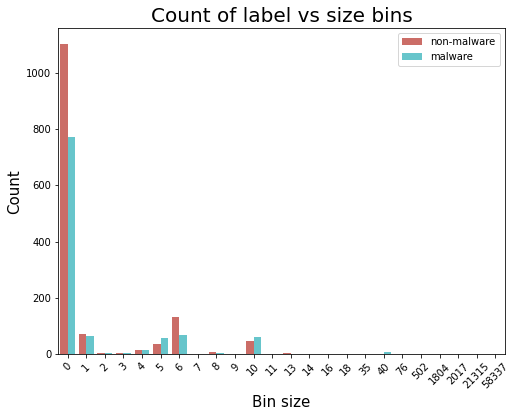

chi_2 statistic: 51.39
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [114]:
plot_chi(header,'optional.major_image_version')

<Figure size 432x288 with 0 Axes>

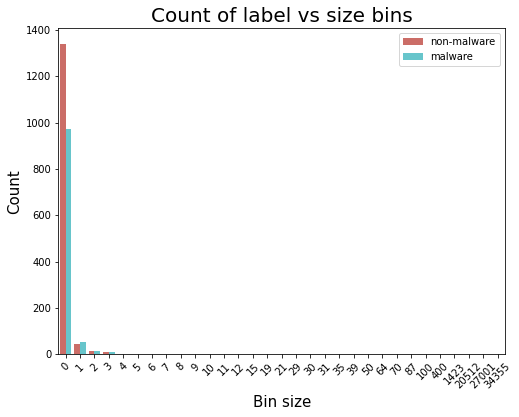

chi_2 statistic: 30.27
p_value: 0.18
significant level 0.05
Do not reject H0


In [115]:
plot_chi(header,'optional.minor_image_version')

<Figure size 432x288 with 0 Axes>

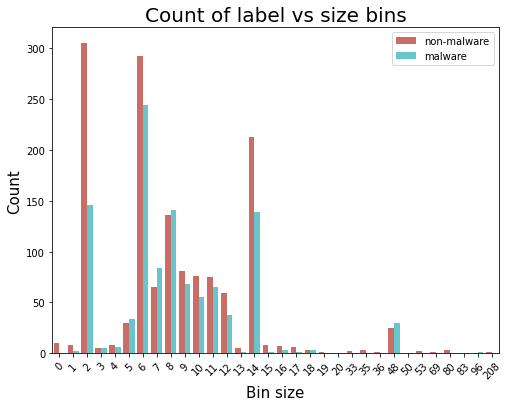

chi_2 statistic: 79.59
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [118]:
plot_chi(header,'optional.major_linker_version')
#include

<Figure size 432x288 with 0 Axes>

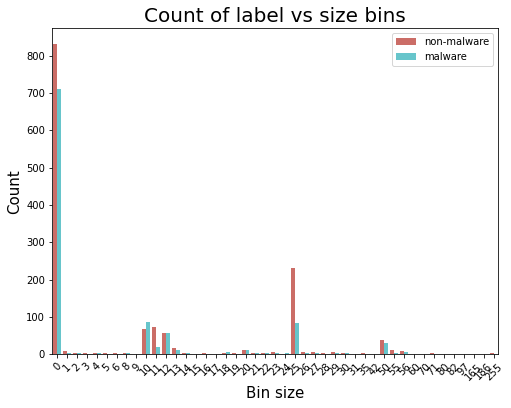

chi_2 statistic: 109.28
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [120]:
plot_chi(header, 'optional.minor_linker_version')

<Figure size 432x288 with 0 Axes>

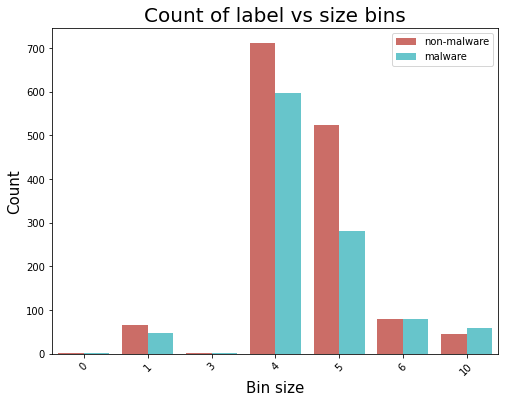

chi_2 statistic: 36.64
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [121]:
plot_chi(header,'optional.major_operating_system_version')

<Figure size 432x288 with 0 Axes>

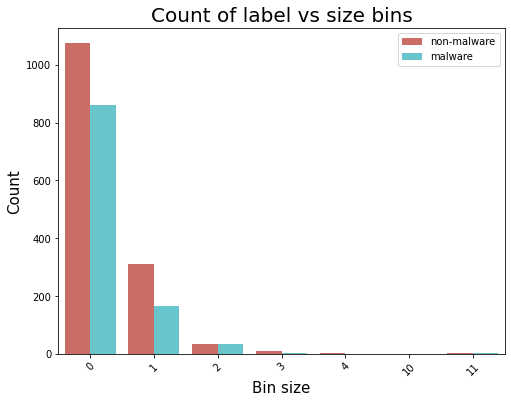

chi_2 statistic: 20.53
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [123]:
plot_chi(header, 'optional.minor_operating_system_version')

<Figure size 432x288 with 0 Axes>

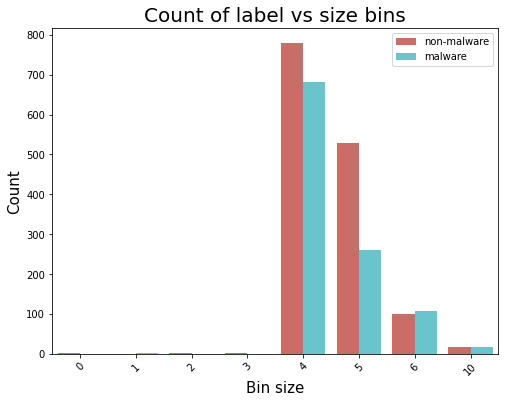

chi_2 statistic: 52.51
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [124]:
plot_chi(header, 'optional.major_subsystem_version')

<Figure size 432x288 with 0 Axes>

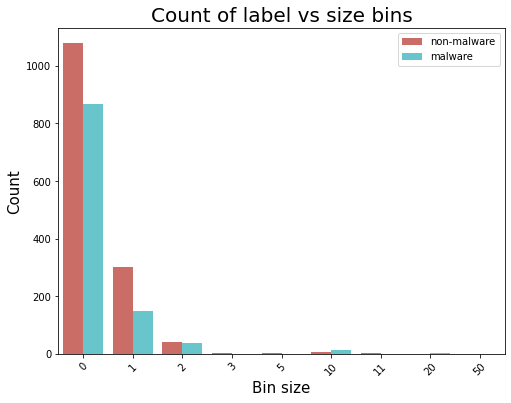

chi_2 statistic: 29.29
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [125]:
plot_chi(header, 'optional.minor_subsystem_version')

In [127]:
header['optional.sizeof_code'].describe()

count         3864.00
mean       2423430.25
std       78738714.42
min              0.00
25%          23040.00
50%          93696.00
75%         376320.00
max     4294967295.00
Name: optional.sizeof_code, dtype: float64

In [116]:
header.columns

Index(['coff.timestamp', 'coff.machine', 'coff.characteristics', 'optional.subsystem', 'optional.dll_characteristics', 'optional.magic', 'optional.major_image_version', 'optional.minor_image_version', 'optional.major_linker_version', 'optional.minor_linker_version', 'optional.major_operating_system_version', 'optional.minor_operating_system_version', 'optional.major_subsystem_version', 'optional.minor_subsystem_version', 'optional.sizeof_code', 'optional.sizeof_headers', 'optional.sizeof_heap_commit', 'label'], dtype='object')

In [ ]:
identified now = 

In [128]:
var1 = ['optional.subsystem', 'optional.dll_characteristics', 'optional.major_image_version', 'optional.major_linker_version', 'optional.minor_linker_version', 'optional.major_operating_system_version', 'optional.minor_operating_system_version', 'optional.major_subsystem_version', 'optional.minor_subsystem_version']

In [9]:
coff_characteristics = df_unpack_list(header['coff.characteristics'])

In [10]:
coff_characteristics.head(2)

,coff.characteristics.aggressive_ws_trim,coff.characteristics.bytes_reversed_hi,coff.characteristics.bytes_reversed_lo,coff.characteristics.chara_32bit_machine,coff.characteristics.debug_stripped,coff.characteristics.dll,coff.characteristics.executable_image,coff.characteristics.large_address_aware,coff.characteristics.line_nums_stripped,coff.characteristics.local_syms_stripped,coff.characteristics.net_run_from_swap,coff.characteristics.relocs_stripped,coff.characteristics.removable_run_from_swap,coff.characteristics.system,coff.characteristics.up_system_only
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [11]:
optional_ddl = df_unpack_list(header['optional.dll_characteristics'])

In [12]:
optional_ddl.head(2)

,optional.dll_characteristics.appcontainer,optional.dll_characteristics.dynamic_base,optional.dll_characteristics.force_integrity,optional.dll_characteristics.guard_cf,optional.dll_characteristics.high_entropy_va,optional.dll_characteristics.no_bind,optional.dll_characteristics.no_isolation,optional.dll_characteristics.no_seh,optional.dll_characteristics.nx_compat,optional.dll_characteristics.terminal_server_aware,optional.dll_characteristics.wdm_driver,optional.dll_characteristics.empty
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
header_unpacked = pd.concat([df.label,header.loc[:,'coff.timestamp':'coff.machine'],coff_characteristics,header.loc[:,'optional.subsystem'],optional_ddl,header.loc[:,'optional.magic':'optional.sizeof_heap_commit']], axis=1)

In [158]:
header_unpacked.head()

,coff.timestamp,coff.machine,coff.characteristics.aggressive_ws_trim,coff.characteristics.bytes_reversed_hi,coff.characteristics.bytes_reversed_lo,coff.characteristics.chara_32bit_machine,coff.characteristics.debug_stripped,coff.characteristics.dll,coff.characteristics.executable_image,coff.characteristics.large_address_aware,coff.characteristics.line_nums_stripped,coff.characteristics.local_syms_stripped,coff.characteristics.net_run_from_swap,coff.characteristics.relocs_stripped,coff.characteristics.removable_run_from_swap,coff.characteristics.system,coff.characteristics.up_system_only,optional.subsystem,optional.dll_characteristics.appcontainer,optional.dll_characteristics.dynamic_base,optional.dll_characteristics.force_integrity,optional.dll_characteristics.guard_cf,optional.dll_characteristics.high_entropy_va,optional.dll_characteristics.no_bind,optional.dll_characteristics.no_isolation,optional.dll_characteristics.no_seh,optional.dll_characteristics.nx_compat,optional.dll_characteristics.terminal_server_aware,optional.dll_characteristics.wdm_driver,optional.dll_characteristics.empty,optional.magic,optional.major_image_version,optional.minor_image_version,optional.major_linker_version,optional.minor_linker_version,optional.major_operating_system_version,optional.minor_operating_system_version,optional.major_subsystem_version,optional.minor_subsystem_version,optional.sizeof_code,optional.sizeof_headers,optional.sizeof_heap_commit
0,1124149349,I386,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,WINDOWS_GUI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,PE32,0,0,7,10,4,0,4,0,26624,1024,4096
1,1091600092,I386,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,WINDOWS_GUI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,PE32,21315,20512,7,10,5,1,4,0,455680,1024,4096
2,892092777,I386,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,WINDOWS_GUI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,PE32,5,0,6,0,5,0,4,0,80896,1024,4096
3,708992537,I386,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,WINDOWS_GUI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,PE32,0,0,2,25,1,0,4,0,36864,1024,4096
4,938258311,I386,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,WINDOWS_GUI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,PE32,5,0,5,12,5,0,4,0,34304,1536,4096


### Variable "section"

In [15]:
section = pd.json_normalize(df.section, record_prefix = "section")

NameError: name 'df' is not defined

In [9]:
section['label']=df.label

In [9]:
section.head()

NameError: name 'section' is not defined

In [ ]:
# let's analyse section properties by creating dataframe with properties

In [10]:
section_list_malware = []

In [11]:
for sec in section.sections[section.label == 1]:
    section_list_malware.append(pd.DataFrame(sec))

In [12]:
concated_m = pd.concat(section_list_malware)

In [8]:
concated_m.head(20)

NameError: name 'concated_m' is not defined

In [151]:
# creating a set of unique properties for malware
mal = set(concated_m.props.explode().unique())

In [ ]:
# the same for beingware

In [144]:
section_list = []

In [145]:
for sec in section.sections[section.label == 0]:
    section_list.append(pd.DataFrame(sec))

In [146]:
concated = pd.concat(section_list)

In [152]:
bei = set(concated.props.explode().unique())

In [191]:
# difference between values, we are looking for special properties for malware
my = list(mal - bei)
my

['TYPE_NO_PAD', 'MEM_LOCKED', 'LNK_COMDAT', 'LNK_NRELOC_OVFL']

In [176]:
ex = concated_m.props.explode()

In [197]:
concated_m.props = concated_m.props.astype(str)

In [202]:
section['sections'] = section['sections'].astype(str)

In [204]:
section[section.sections.str.contains("TYPE_NO_PAD")]

,entry,sections,label
2070,.crt1,"[{'name': '.crt1', 'size': 28672, 'entropy': 6...",1
2569,.rdata,"[{'name': '.rdata', 'size': 9216, 'entropy': 6...",1
3518,.text,"[{'name': '', 'size': 2048, 'entropy': 6.26038...",-1
3911,.text,"[{'name': '.text', 'size': 12288, 'entropy': 6...",1
5509,.text,"[{'name': '.text', 'size': 200704, 'entropy': ...",1
5524,.text,"[{'name': '.text\x01', 'size': 28672, 'entropy...",1
5757,.text,"[{'name': '.text\x01', 'size': 28672, 'entropy...",1
5845,.text,"[{'name': '.text', 'size': 114688, 'entropy': ...",-1


In [168]:
concated_m['contain']= concated_m.props.apply(lambda x: (1 if 'MEM_LOCKED' in x))

SyntaxError: invalid syntax (<ipython-input-168-1fb3b022a561>, line 1)

## EDA

In [149]:
df['label'].value_counts()

 0    2750
 1    1932
-1    1318
Name: label, dtype: int64

In [110]:
malware = header_unpacked[df.label == 1 ].copy()

In [111]:
beingware = header_unpacked[df.label == 0 ].copy()

In [112]:
malware['coff.characteristics.dll'].value_counts()

0.00    1839
1.00      93
Name: coff.characteristics.dll, dtype: int64

In [113]:
beingware['coff.characteristics.dll'].value_counts()

0.00    1533
1.00    1217
Name: coff.characteristics.dll, dtype: int64

In [114]:
malware.describe()

,label,coff.timestamp,coff.characteristics.aggressive_ws_trim,coff.characteristics.bytes_reversed_hi,coff.characteristics.bytes_reversed_lo,coff.characteristics.chara_32bit_machine,coff.characteristics.debug_stripped,coff.characteristics.dll,coff.characteristics.executable_image,coff.characteristics.large_address_aware,coff.characteristics.line_nums_stripped,coff.characteristics.local_syms_stripped,coff.characteristics.net_run_from_swap,coff.characteristics.relocs_stripped,coff.characteristics.removable_run_from_swap,coff.characteristics.system,coff.characteristics.up_system_only,optional.dll_characteristics.appcontainer,optional.dll_characteristics.dynamic_base,optional.dll_characteristics.force_integrity,optional.dll_characteristics.guard_cf,optional.dll_characteristics.high_entropy_va,optional.dll_characteristics.no_bind,optional.dll_characteristics.no_isolation,optional.dll_characteristics.no_seh,optional.dll_characteristics.nx_compat,optional.dll_characteristics.terminal_server_aware,optional.dll_characteristics.wdm_driver,optional.dll_characteristics.empty,optional.major_image_version,optional.minor_image_version,optional.major_linker_version,optional.minor_linker_version,optional.major_operating_system_version,optional.minor_operating_system_version,optional.major_subsystem_version,optional.minor_subsystem_version,optional.sizeof_code,optional.sizeof_headers,optional.sizeof_heap_commit
count,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00,1932.00
mean,1.00,1335718057.02,0.00,0.17,0.17,0.97,0.07,0.05,1.00,0.04,0.58,0.58,0.00,0.52,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.01,0.01,0.00,0.13,0.37,0.45,0.00,0.51,1.12,0.31,8.23,10.52,4.33,0.31,4.43,0.28,4452641.93,4960.23,13663.93
std,0.00,323206620.45,0.05,0.37,0.38,0.16,0.26,0.21,0.00,0.20,0.49,0.49,0.03,0.50,0.02,0.05,0.02,0.00,0.48,0.00,0.07,0.10,0.08,0.05,0.34,0.48,0.50,0.00,0.50,4.14,2.40,8.78,18.58,0.85,0.83,0.55,0.71,111322158.40,133594.64,102271.21
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00,0.00,0.00,448.00,0.00
25%,1.00,1288891385.75,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,4.00,0.00,4.00,0.00,32768.00,1024.00,4096.00
50%,1.00,1467119444.50,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,6.00,0.00,4.00,0.00,4.00,0.00,135168.00,1024.00,4096.00
75%,1.00,1520202898.75,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,11.00,25.00,5.00,1.00,5.00,0.00,443392.00,4096.00,4096.00
max,1.00,3968609835.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,40.00,50.00,208.00,255.00,10.00,11.00,6.00,10.00,4294967295.00,5873664.00,1286144.00


In [115]:
beingware.describe()

,label,coff.timestamp,coff.characteristics.aggressive_ws_trim,coff.characteristics.bytes_reversed_hi,coff.characteristics.bytes_reversed_lo,coff.characteristics.chara_32bit_machine,coff.characteristics.debug_stripped,coff.characteristics.dll,coff.characteristics.executable_image,coff.characteristics.large_address_aware,coff.characteristics.line_nums_stripped,coff.characteristics.local_syms_stripped,coff.characteristics.net_run_from_swap,coff.characteristics.relocs_stripped,coff.characteristics.removable_run_from_swap,coff.characteristics.system,coff.characteristics.up_system_only,optional.dll_characteristics.appcontainer,optional.dll_characteristics.dynamic_base,optional.dll_characteristics.force_integrity,optional.dll_characteristics.guard_cf,optional.dll_characteristics.high_entropy_va,optional.dll_characteristics.no_bind,optional.dll_characteristics.no_isolation,optional.dll_characteristics.no_seh,optional.dll_characteristics.nx_compat,optional.dll_characteristics.terminal_server_aware,optional.dll_characteristics.wdm_driver,optional.dll_characteristics.empty,optional.major_image_version,optional.minor_image_version,optional.major_linker_version,optional.minor_linker_version,optional.major_operating_system_version,optional.minor_operating_system_version,optional.major_subsystem_version,optional.minor_subsystem_version,optional.sizeof_code,optional.sizeof_headers,optional.sizeof_heap_commit
count,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00,2750.00
mean,0.00,1254252801.00,0.00,0.07,0.07,0.86,0.04,0.44,1.00,0.17,0.46,0.44,0.01,0.32,0.02,0.00,0.00,0.00,0.46,0.00,0.05,0.09,0.00,0.00,0.28,0.48,0.33,0.00,0.41,56.22,53.13,9.85,5.68,4.81,0.23,4.67,0.40,403437.02,1853.82,4763.28
std,0.00,510888160.18,0.05,0.25,0.25,0.35,0.18,0.50,0.02,0.38,0.50,0.50,0.10,0.47,0.12,0.00,0.00,0.06,0.50,0.06,0.22,0.28,0.02,0.02,0.45,0.50,0.47,0.03,0.49,1378.02,1142.25,9.13,10.62,1.87,0.58,1.23,1.67,1390395.90,3116.77,28173.85
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,392.00,0.00
25%,0.00,1089485494.75,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,4.00,0.00,4.00,0.00,12288.00,1024.00,4096.00
50%,0.00,1247682501.50,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,0.00,4.00,0.00,4.00,0.00,58880.00,1024.00,4096.00
75%,0.00,1514777852.50,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,4.00,0.00,11.00,10.00,5.00,0.00,5.00,0.00,276096.00,4096.00,4096.00
max,0.00,4279508411.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,58337.00,34355.00,83.00,82.00,10.00,11.00,10.00,50.00,29429760.00,131072.00,1048576.00


In [107]:
header_unpacked.columns

Index(['label', 'coff.timestamp', 'coff.machine', 'coff.characteristics.aggressive_ws_trim', 'coff.characteristics.bytes_reversed_hi', 'coff.characteristics.bytes_reversed_lo', 'coff.characteristics.chara_32bit_machine', 'coff.characteristics.debug_stripped', 'coff.characteristics.dll', 'coff.characteristics.executable_image', 'coff.characteristics.large_address_aware', 'coff.characteristics.line_nums_stripped', 'coff.characteristics.local_syms_stripped', 'coff.characteristics.net_run_from_swap', 'coff.characteristics.relocs_stripped', 'coff.characteristics.removable_run_from_swap', 'coff.characteristics.system', 'coff.characteristics.up_system_only', 'optional.subsystem', 'optional.dll_characteristics.appcontainer', 'optional.dll_characteristics.dynamic_base', 'optional.dll_characteristics.force_integrity', 'optional.dll_characteristics.guard_cf', 'optional.dll_characteristics.high_entropy_va', 'optional.dll_characteristics.no_bind', 'optional.dll_characteristics.no_isolation',
      

In [14]:
coff_characteristics_lb = pd.concat([coff_characteristics,df.label],axis=1)

In [16]:
coff_characteristics_lb.dtypes

coff.characteristics.aggressive_ws_trim         float64
coff.characteristics.bytes_reversed_hi          float64
coff.characteristics.bytes_reversed_lo          float64
coff.characteristics.chara_32bit_machine        float64
coff.characteristics.debug_stripped             float64
coff.characteristics.dll                        float64
coff.characteristics.executable_image           float64
coff.characteristics.large_address_aware        float64
coff.characteristics.line_nums_stripped         float64
coff.characteristics.local_syms_stripped        float64
coff.characteristics.net_run_from_swap          float64
coff.characteristics.relocs_stripped            float64
coff.characteristics.removable_run_from_swap    float64
coff.characteristics.system                     float64
coff.characteristics.up_system_only             float64
label                                             int64
dtype: object

In [20]:
cf = coff_characteristics_lb[coff_characteristics_lb.label.isin([0,1])].copy()

In [ ]:
sample.head()

In [43]:
sample = pd.concat([cf.iloc[:,12:15],cf.label],axis=1)

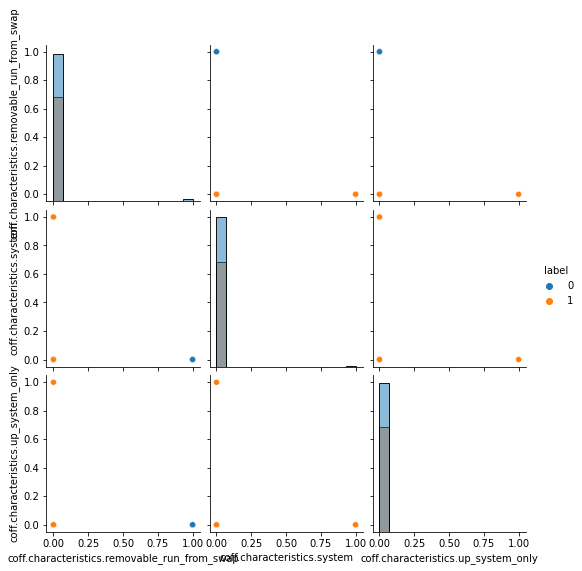

In [44]:
sns.pairplot(sample, hue = 'label', diag_kind = 'hist')
plt.show()

In [45]:
from sklearn.manifold import TSNE

In [46]:
m = TSNE(learning_rate = 50)

In [61]:
cf_nolabel = cf.drop('label', axis =1)

In [62]:
tsne_features = m.fit_transform(cf_nolabel)

In [63]:
ex = pd.concat([pd.DataFrame(tsne_features, columns=['x','y']),cf.label],axis=1)

<AxesSubplot:xlabel='x', ylabel='y'>

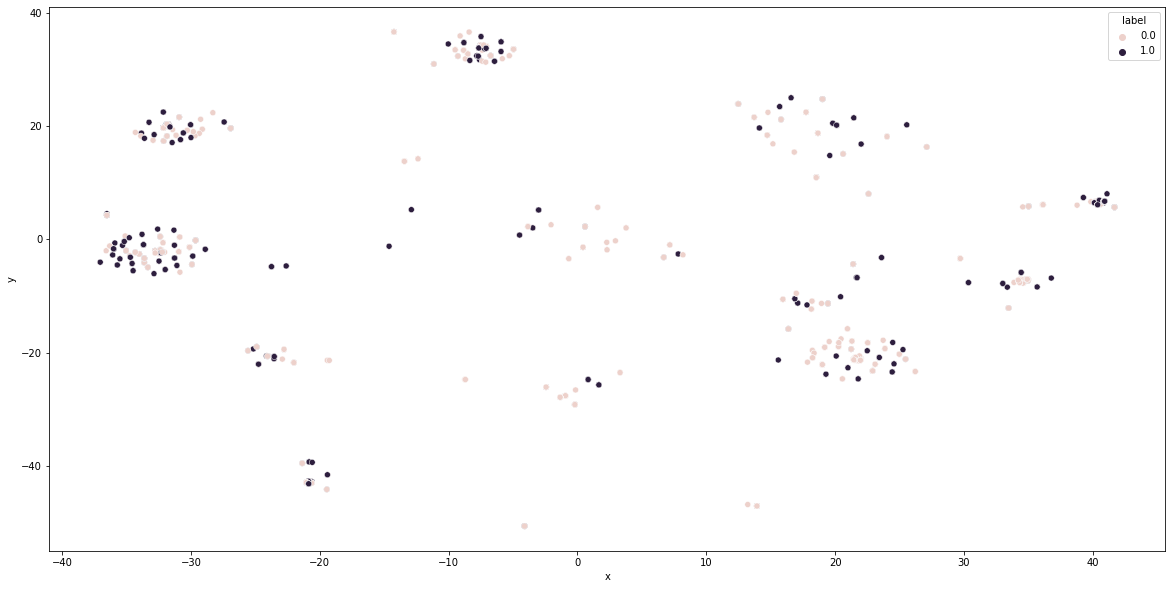

In [64]:

plt.figure(figsize=(20,10))
sns.scatterplot(x="x", y="y", hue='label', data=ex)

In [131]:
from sklearn.preprocessing import StandardScaler

In [132]:
from sklearn.decomposition import PCA

In [16]:
scaler = StandardScaler()

In [17]:
std_df = scaler.fit_transform(cf_nolabel)

NameError: name 'cf_nolabel' is not defined

In [69]:
std_df

array([[-4.85278900e-02, -3.50402304e-01, -3.52703297e-01, ...,
        -9.62768875e-02, -2.92415162e-02, -1.46160722e-02],
       [ 2.06067068e+01, -3.50402304e-01, -3.52703297e-01, ...,
        -9.62768875e-02, -2.92415162e-02, -1.46160722e-02],
       [-4.85278900e-02, -3.50402304e-01, -3.52703297e-01, ...,
        -9.62768875e-02, -2.92415162e-02, -1.46160722e-02],
       ...,
       [-4.85278900e-02, -3.50402304e-01, -3.52703297e-01, ...,
        -9.62768875e-02, -2.92415162e-02, -1.46160722e-02],
       [-4.85278900e-02, -3.50402304e-01, -3.52703297e-01, ...,
        -9.62768875e-02, -2.92415162e-02, -1.46160722e-02],
       [-4.85278900e-02, -3.50402304e-01, -3.52703297e-01, ...,
        -9.62768875e-02, -2.92415162e-02, -1.46160722e-02]])

In [18]:
pca = PCA()

In [85]:
pca.fit_transform(cf_nolabel)

array([[-8.85683523e-01, -2.55600147e-01, -3.43617240e-01, ...,
         5.77250412e-04, -3.57205769e-04, -7.02265631e-04],
       [-8.87543787e-01, -2.55263218e-01, -3.47944277e-01, ...,
        -1.75406528e-04, -3.46633476e-04, -5.99429508e-04],
       [ 6.84568435e-02,  8.14573100e-04,  3.49968438e-02, ...,
        -1.52628575e-03,  1.57392982e-03,  1.15392879e-03],
       ...,
       [-7.18325555e-01, -1.67554142e-01, -4.46588690e-01, ...,
         2.80359411e-03,  6.11567876e-03, -6.06782574e-03],
       [ 2.19472713e-01, -8.73796746e-01, -2.75760378e-04, ...,
        -3.63502655e-03, -1.20764145e-03,  1.60645525e-04],
       [-8.85683523e-01, -2.55600147e-01, -3.43617240e-01, ...,
         5.77250412e-04, -3.57205769e-04, -7.02265631e-04]])

In [ ]:
pca.

In [75]:
mask = pca.explained_variance_ratio_ >= 0.05

In [78]:
cf_nolabel.shape

(4682, 15)

In [80]:
cf_nolabel.loc[:,mask]

,coff.characteristics.aggressive_ws_trim,coff.characteristics.bytes_reversed_hi,coff.characteristics.bytes_reversed_lo,coff.characteristics.chara_32bit_machine,coff.characteristics.debug_stripped,coff.characteristics.dll,coff.characteristics.executable_image,coff.characteristics.large_address_aware,coff.characteristics.line_nums_stripped,coff.characteristics.local_syms_stripped
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
5996,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
5997,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
5998,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [87]:
pca.explained_variance_ratio_.cumsum()

array([0.46574456, 0.63880796, 0.76482196, 0.87263098, 0.93449941,
       0.96773317, 0.9786357 , 0.98801028, 0.99545179, 0.99710848,
       0.99849175, 0.99921002, 0.99970922, 0.99986058, 1.        ])

In [83]:
pca.components_

array([[ 1.74015828e-02,  3.39330956e-01,  3.37545467e-01,
         3.04579965e-01,  5.65174893e-02, -2.72433226e-01,
         1.28727102e-02, -3.11059214e-01,  4.47950646e-01,
         4.51086577e-01,  3.51077017e-03,  3.14224235e-01,
         2.32232230e-02, -3.56303078e-03, -8.25042070e-03],
       [-2.46306208e-02,  2.24978777e-01,  2.24564241e-01,
        -2.62541997e-01,  3.78851037e-02,  3.52687302e-02,
        -6.96218998e-03,  2.80526720e-01,  2.83882492e-02,
         2.61771871e-02,  6.16360992e-01, -5.08929766e-02,
         5.84018330e-01, -1.46235748e-02,  1.50745620e-01],
       [ 5.04649759e-02, -5.01559739e-01, -5.02444226e-01,
         3.07286848e-01,  9.27181854e-02, -1.38711579e-01,
         1.07058719e-02, -2.91562007e-01,  2.56611720e-02,
         2.45613394e-02,  3.16786696e-01,  2.56832477e-01,
         3.34624615e-01,  1.18060674e-02,  7.97723015e-02],
       [ 1.09892312e-01, -2.19125752e-01, -2.22665521e-01,
        -4.72841569e-01,  3.13642979e-01, -7.42355923

In [133]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [134]:
clf = SVC(C=2)

In [135]:
from sklearn.model_selection import train_test_split

In [148]:
var1 = [ 'optional.major_image_version', 'optional.major_linker_version', 'optional.minor_linker_version', 'optional.major_operating_system_version', 'optional.minor_operating_system_version', 'optional.major_subsystem_version', 'optional.minor_subsystem_version']

In [141]:
var1 = ['coff.machine','optional.subsystem', 'optional.dll_characteristics', 'optional.major_image_version', 'optional.major_linker_version', 'optional.minor_linker_version', 'optional.major_operating_system_version', 'optional.minor_operating_system_version', 'optional.major_subsystem_version', 'optional.minor_subsystem_version']

In [149]:
header[var1].head()

,optional.major_image_version,optional.major_linker_version,optional.minor_linker_version,optional.major_operating_system_version,optional.minor_operating_system_version,optional.major_subsystem_version,optional.minor_subsystem_version
0,0,2,50,4,0,4,0
1,0,14,11,5,1,5,1
2,0,10,0,5,1,5,1
3,0,5,12,4,0,4,0
4,0,2,25,4,0,4,0


In [140]:
X['coff.machine'] = pd.get_dummies(header['coff.machine'])

ValueError: Wrong number of items passed 7, placement implies 1

In [150]:
X_train, X_test, y_train, y_test = train_test_split(header[var1], header.label, test_size=0.2, random_state=42)

In [151]:
clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [106]:
accuracy_score(y_test,clf.predict(X_test))

0.7069857697283312